# Class Activation Mapping

> Introduced that CNNs trained for Classification tasks are also able to localize them. The paper explains how the Global Average Pooling layer explicitly enables the model to learn Class Discriminative features.

Paper: [Learning Deep Features for Discriminative Localization](https://arxiv.org/abs/1512.04150)

In [ ]:
from fastai2.vision.all import *
from fast_impl.core import get_module, arch_summary, min_max_scale

In [ ]:
path = untar_data(URLs.IMAGEWOOF_320)

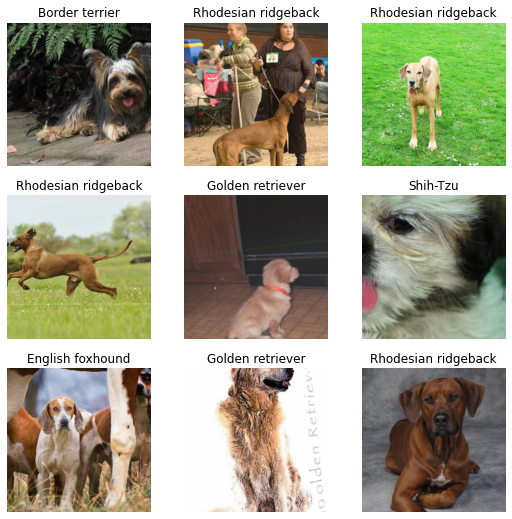

In [ ]:
lbl_dict = dict(
  n02086240= 'Shih-Tzu',
  n02087394= 'Rhodesian ridgeback',
  n02088364= 'Beagle',
  n02089973= 'English foxhound',
  n02093754= 'Australian terrier',
  n02096294= 'Border terrier',
  n02099601= 'Golden retriever',
  n02105641= 'Old English sheepdog',
  n02111889= 'Samoyed',
  n02115641= 'Dingo'
)
dblock = DataBlock(blocks=(ImageBlock,CategoryBlock),
                   get_items=get_image_files,
                   splitter=GrandparentSplitter(valid_name='val'),
                   get_y=Pipeline([parent_label,lbl_dict.__getitem__]),
                   item_tfms=Resize(320),
                   batch_tfms=[*aug_transforms(size=224),Normalize.from_stats(*imagenet_stats)])
dls = dblock.dataloaders(path,bs=128)
dls.show_batch()

In [ ]:
exp_name='resnet34'
save_model = SaveModelCallback(monitor='error_rate',fname=exp_name)

In [ ]:
body = create_body(resnet34,cut=-2);
nf = num_features_model(body)
head = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),Flatten(),nn.Linear(nf,dls.c))
model = nn.Sequential(body,head)

In [ ]:
def resnet_split(m): return L(m[0][:6], m[0][6:], m[1:]).map(params)

In [ ]:
learn= Learner(dls,model,metrics=error_rate,cbs=save_model,
               opt_func=ranger,splitter=resnet_split,
               model_dir='/content/models')
learn.fit_flat_cos(5,lr=1e-3)
learn.unfreeze()
learn.fit_flat_cos(4,lr=1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.448790,0.403086,0.120641,01:46
1,0.306508,0.330783,0.098244,01:41
2,0.262418,0.337453,0.101553,01:41
3,0.244381,0.634867,0.172563,01:41
4,0.163687,0.274807,0.083736,01:41


epoch,train_loss,valid_loss,error_rate,time
0,0.083525,0.250450,0.075083,01:42
1,0.065635,0.247281,0.069738,01:41
2,0.052776,0.258075,0.072792,01:41
3,0.038071,0.254557,0.069738,01:42


In [ ]:
b = learn.dls.one_batch()

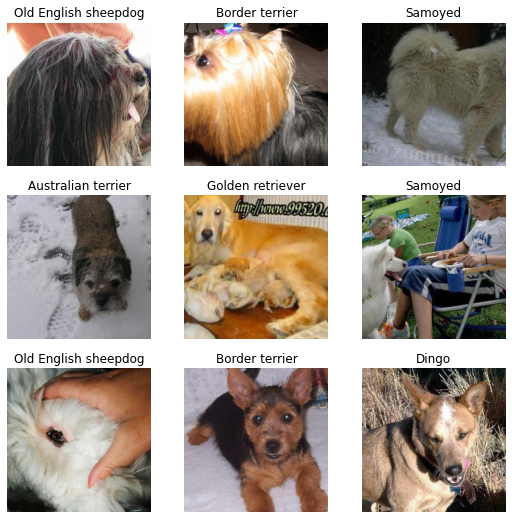

In [ ]:
learn.dls.show_batch(b)

Same as above, but here to clarify the fact that we'll be working with the same image when indexed into batch for CAM/GradCAM

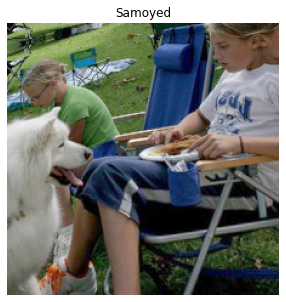

In [ ]:
idx=5
x,y = b[0][idx],b[1][idx]
x,y = learn.dls.decode_batch((x[None],y[None]))[0]
show_image(x,title=y);

In [ ]:
xb,yb = b[0][idx][None],b[1][idx][None]

# Class Activation Mappping

CAM highlights the class specific desciminative region by mapping predicted class score to previous convolutional layer. 

<div style="text-align:center"><img src="images/cam.png" style="width:50%"></div>

$$
M_c(x,y) = \sum_k w_c^kf_k(x,y)
$$

Here $M_c$ defines CAM for class `C`, $w_c^k$ is the weight corresponding to class c for unit k. $f_k(x,y)$ represent the activation of unit k in the last convolutional layer at spatial location (x,y)



In [ ]:
m = learn.model

We want the output of penultimate layer from encoder part as last layer of it is Average Pool. Thus, we'll index that layer as `m[0][-2]`.

In [ ]:
hook = hook_output(m[0])

In [ ]:
with torch.no_grad(): output = m.eval()(xb)

We know the label, let's check whether the model got it right

In [ ]:
learn.dls.vocab[ output.argmax().item()]

'Samoyed'

Weights of Linear layer

In [ ]:
wt = learn.model[1][-1].weight; wt.shape

torch.Size([10, 512])

Activation maps

In [ ]:
act = hook.stored[0]; act.shape

torch.Size([512, 7, 7])

We want to multiply a matrix with 3D tensor, in this case, a matrix of shape 10 x 512 and a Tensor of 512,7,7. We can do this by defining our custom matrix multiplication using `torch.einsum`

In [ ]:
cam = torch.einsum('ck,kij->cij',wt,act).sum(0); cam.shape

torch.Size([7, 7])

In [ ]:
sz = xb.shape[-1]; sz

224

In [ ]:
def show_heatmap(x,cam,sz,merge=False,figsize=(7,7),
                 alpha=0.6,interpolation='spline36',
                 cmap='magma'):
  "Used to show CAM/gradcam"
  if merge: figsize=(4,4)
  if not merge: alpha=1.
  _,axs = subplots(1,1 if merge else 2,figsize=figsize)
  if not isinstance(x,TensorImage): x = TensorImage(x)
  x.show(ax=axs[0],title='Image' if not merge else None)
  if cam.dim()==2: cam = cam[None]
  show_image(min_max_scale(cam),ax=axs[0 if merge else 1],
             extent=(1,sz,sz,1),alpha=alpha,
             interpolation=interpolation,cmap=cmap,
             title='Heatmap' if not merge else None);

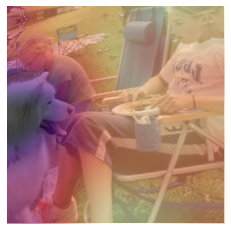

In [ ]:
show_heatmap(x,cam,224,merge=True)

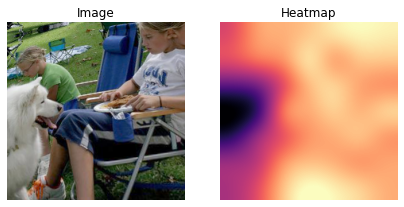

In [ ]:
show_heatmap(x,cam,224)

# Putting it together

In [ ]:
m = learn.model

In [ ]:
xb,yb = dls.one_batch()

The batch size is 128, so any idx in [0,127] is valid for the following snippet. We can specify `max_n` to show that many images.

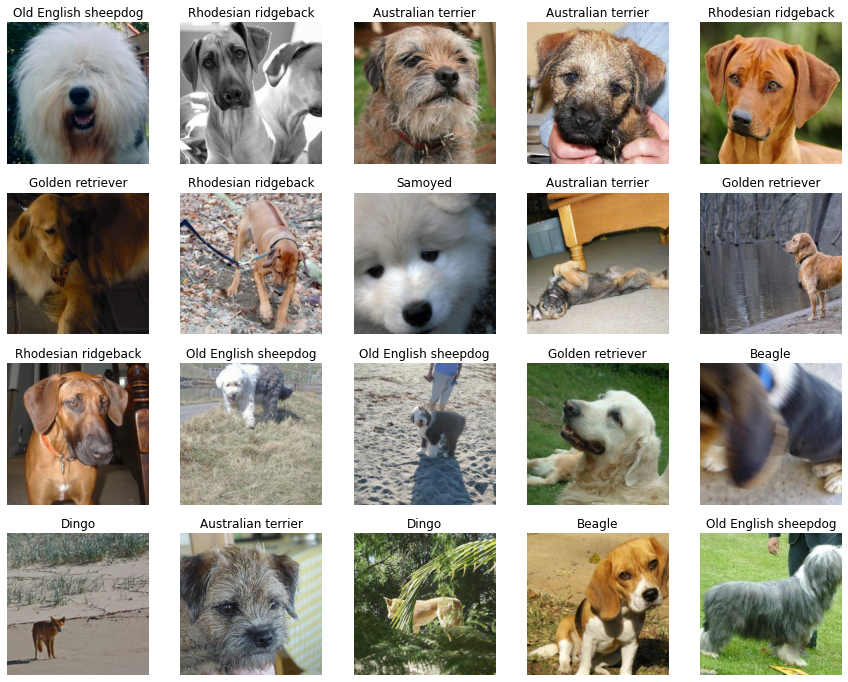

In [ ]:
dls.show_batch((xb,yb),ncols=5,max_n=20)

Actual   : Dingo
Predicted: Dingo


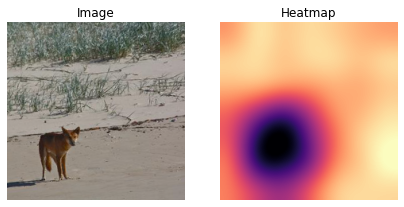

In [ ]:
idx=15
xb,yb = xb[idx][None],yb[idx][None]
x_dec,y_dec = learn.dls.decode_batch((xb,yb))[0]
with hook_output(m[0]) as hook:
  y_pred = m.eval()(xb) 
  pred_cls = dls.vocab[y_pred.argmax().item()]
  print(f"{'Actual':<9}: {y_dec}\nPredicted: {pred_cls}")
  act = hook.stored[0]
  cam = torch.einsum('ck,kij->cij', m[1][-1].weight, act).sum(0)
  show_heatmap(x_dec,cam,sz=x.shape[-1])

# Custom test image

Now let's make this work for any input image.

In [ ]:
# It's an image of Shih-tzu
url = 'https://t2conline.com/wp-content/uploads/2020/01/shutterstock_1124417876.jpg'
fname = 'test-shih-tzu.jpg'
download_url(url,dest=fname)

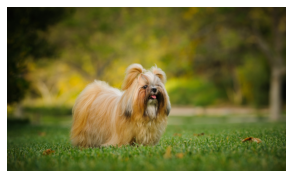

In [ ]:
img = PILImage.create(fname); img.show(figsize=(5,5))

Fastai2's `test_dl` applies your validation transforms to given image. So you need to exhibit all the `type_tfms` before passing an item to dataloader. You can find them as follows:

In [ ]:
dls.tfms

(#2) [Pipeline: PILBase.create,Pipeline: parent_label -> dict.__getitem__ -> Categorize]

We've created `PILImage` as per the pipeline and need a bit of extra work for label

In [ ]:
xb, = first(dls.test_dl([img]))

In [ ]:
y_lbl = dls.vocab[-1]; y_lbl

'Shih-Tzu'

In [ ]:
yb = dls.categorize(y_lbl)[None]; yb

tensor([9])

Putting it in a handy function

In [ ]:
def create_batch(fname,lbl_idx):
  """Create test_batch from filename and label index
  Refer `dls.vocab` to find validation index
  """
  x = PILImage.create(fname)
  xb, = first(dls.test_dl([img]))
  yb = dls.categorize(dls.vocab[-1])[None]
  return xb,yb

In [ ]:
xb,yb = create_batch(fname,9)

In [ ]:
def show_cam(learn,xb,yb,act_path:list=[0], wt_path:list=[1,-1],merge=True):
  """Show CAM for a given image
  `act_path`: list of indices to reach activation map layer
  `wt_path`: list of indices to reach weight layer
  `merge`: to use same axis for image and mask
  """
  m,dls = learn.model,learn.dls
  act_layer = get_module(model,act_path)  
  wt_layer = get_module(model,wt_path)
  # pdb.set_trace()
  with hook_output(act_layer) as hook:
    y_pred = m.eval()(xb) 
    pred_cls = dls.vocab[y_pred.argmax().item()]
    act = hook.stored[0]
    # pdb.set_trace()
    cam = torch.einsum('ck,kij->cij', wt_layer.weight, act).sum(0)

    x_dec,y_dec = dls.decode_batch((xb,yb))[0]
    print(f"{'Actual':<9}: {ifnone(y_dec,'')}\nPredicted: {pred_cls}")
    show_heatmap(x_dec,cam,sz=x.shape[-1])

We need to specify path to the activation layer and weigtht layer. It could be identified using `arch_summary`

In [ ]:
arch_summary(learn.model,verbose=True)

[0 ] Sequential       : 8   layers
      Conv2d
      BatchNorm2d
      ReLU
      MaxPool2d
      Sequential
      Sequential
      Sequential
      Sequential
[1 ] Sequential       : 3   layers
      AdaptiveAvgPool2d
      Flatten
      Linear


For the activation layer, we can take the output of $0^{th}$ Sequential layer, which essentially is the encoder part of model. "Weight layer" is simply last layer of the model, which can be reached using [1,-1]

Actual   : Shih-Tzu
Predicted: Border terrier


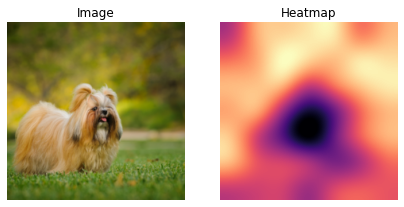

In [ ]:
show_cam(learn,xb,yb,[0],[1,-1])